# import necessary libraries

In [7]:
import os
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from tensorflow.keras import layers, models, datasets, initializers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


#data preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Loading the dataset and preprocessing

In [19]:
train_dir = '/kaggle/input/fer2013/train/'
val_dir = '/kaggle/input/fer2013/test/'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
     fill_mode = 'nearest',
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Create the model

In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate,GlobalAveragePooling2D
from tensorflow.keras.models import Model

def inception_module(x, filters):
    # 1x1 convolution
    conv1x1_1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 convolution followed by 3x3 convolution
    conv1x1_2 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv1x1_2)

    # 1x1 convolution followed by 5x5 convolution
    conv1x1_3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv1x1_3)

    # 3x3 max pooling followed by 1x1 convolution
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    # Concatenate all branches
    inception = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_4], axis=-1)
    return inception

def auxiliary_classifier(x, num_classes):
    # 5x5 average pooling
    x = AveragePooling2D((5, 5), strides=(3, 3), padding='valid')(x)

    # 1x1 convolution
    x = Conv2D(128, (1, 1), padding='same', activation='relu')(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    return output_layer

def GoogleNet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu',name='conv_1_7x7/2')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same',name='max_pool_1_3x3/2')(x)
    
    #Inception module
    x = inception_module(x, [32, 48, 64, 8, 16, 16])
    x = inception_module(x, [64, 64, 96, 16, 48, 32])
    
    aux1 = auxiliary_classifier(x, num_classes)
    
    x = inception_module(x, [64, 64, 96, 16, 48, 32])
    
    aux2 = auxiliary_classifier(x, num_classes)
    
    x= inception_module(x,[80,56,112,12,32,32])
    x= inception_module(x,[64,64,112,12,32,32])

    x = inception_module(x, [64, 64, 96, 16, 48, 32])
   
    x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

    #output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

input_shape = (48, 48, 1)  
num_classes = 7  
model = GoogleNet(input_shape, num_classes)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv_1_7x7/2 (Conv2D)       (None, 24, 24, 32)           320       ['input_9[0][0]']             
                                                                                                  
 max_pool_1_3x3/2 (MaxPooli  (None, 12, 12, 32)           0         ['conv_1_7x7/2[0][0]']        
 ng2D)                                                                                            
                                                                                                  
 conv2d_298 (Conv2D)         (None, 12, 12, 48)           1584      ['max_pool_1_3x3/2[0][0]

# Train the model

In [21]:
checkpoint = ModelCheckpoint('kaggle\working\googleNet_emotion.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50, 
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint]
)


Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.8052 - accuracy: 0.2494
Epoch 1: val_accuracy improved from -inf to 0.24707, saving model to C:\Learning\Materials3-1\Deep Learning\Project\Models\googleNet_emotion.h5
448/448 [==============================] - 64s 113ms/step - loss: 1.8052 - accuracy: 0.2494 - val_loss: 1.7909 - val_accuracy: 0.2471
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.7868 - accuracy: 0.2531
Epoch 2: val_accuracy improved from 0.24707 to 0.26590, saving model to C:\Learning\Materials3-1\Deep Learning\Project\Models\googleNet_emotion.h5
448/448 [==============================] - 47s 105ms/step - loss: 1.7868 - accuracy: 0.2531 - val_loss: 1.7765 - val_accuracy: 0.2659
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.7699 - accuracy: 0.2623
Epoch 3: val_accuracy improved from 0.26590 to 0.28181, saving model to C:\Learning\Materials3-1\Deep Learning\Project\Models\googleNet_emotion.h5
448

In [23]:
model.save_weights('model_weights.h5')

Tiếp tục train model thêm 60 epoch nữa

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.6290
Epoch 1: val_accuracy did not improve from 0.61468
448/448 [==============================] - 47s 105ms/step - loss: 0.9877 - accuracy: 0.6290 - val_loss: 1.0885 - val_accuracy: 0.5868
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 0.9902 - accuracy: 0.6240
Epoch 2: val_accuracy did not improve from 0.61468
448/448 [==============================] - 46s 102ms/step - loss: 0.9902 - accuracy: 0.6240 - val_loss: 1.0674 - val_accuracy: 0.5982
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 0.9840 - accuracy: 0.6277
Epoch 3: val_accuracy did not improve from 0.61468
448/448 [==============================] - 49s 110ms/step - loss: 0.9840 - accuracy: 0.6277 - val_loss: 1.0646 - val_accuracy: 0.6056
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 0.9784 - accuracy: 0.6292
Epoch 4: val_accuracy did not improve from 0.61468
448/448 [=

After 110 epoch, the best validation accuracy rate the model can archive is 63.574%.

# Save the model 

In [28]:
model.save('/kaggle/working/googleNet_emotion.h5')

# Evaluation and Confusion matrix

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def evaluate_model(model, data_generator):
    predictions = model.predict(data_generator)
    true_labels = np.array(data_generator.labels)
    pred_labels = np.argmax(predictions, axis=1)

    acc = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    conf_matrix = confusion_matrix(true_labels, pred_labels)
    print("\nConfusion Matrix:")
    print(conf_matrix)

evaluate_model(model, validation_generator)


113/113 [==============================] - 6s 51ms/step
Accuracy: 0.17762607968793537
Precision: 0.1741079989282378
Recall: 0.17762607968793537
F1 Score: 0.17434617390028073

Confusion Matrix:
[[151   7 102 259 197 139 103]
 [ 17   2   5  30  24  15  18]
 [164  18  93 290 206 132 121]
 [310  12 154 510 334 274 180]
 [204  20 110 334 236 204 125]
 [207  10 119 328 256 197 130]
 [133  12  75 236 160 129  86]]


# Training VS Validation Accuracy

In [30]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
wandb.init(project='FER-2013-Googlenet', entity='dgktrnh')
for epoch in range(len(history.history['loss'])):
    wandb.log({
        'epoch': epoch,
        'loss': history.history['loss'][epoch],
        'val_loss': history.history['val_loss'][epoch],
        'accuracy': history.history['accuracy'][epoch],
        'val_accuracy': history.history['val_accuracy'][epoch]
    })

wandb: Currently logged in as: dgktrnh. Use `wandb login --relogin` to force relogin


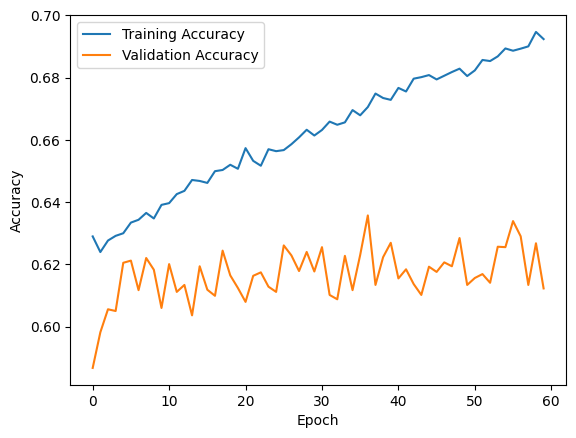

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC Curve

113/113 [==============================] - 14s 121ms/step


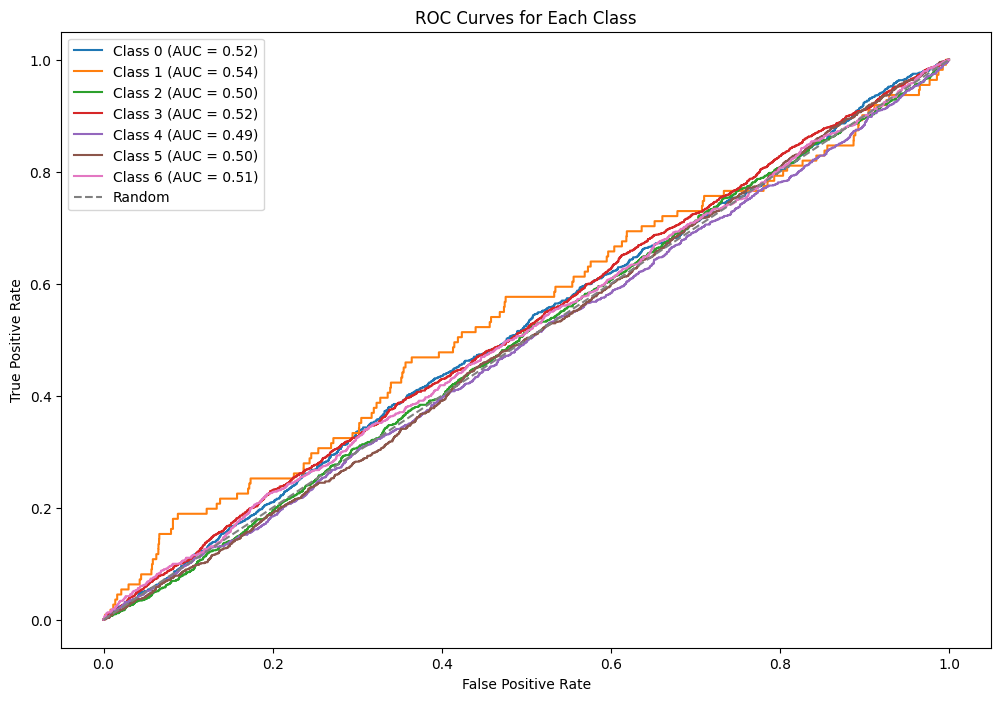

In [33]:
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

plt.figure(figsize=(12, 8))
for i in range(len(train_generator.class_indices)):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.show()


In [34]:
y_pred_classes = np.argmax(y_pred, axis=1)
class_report = classification_report(y_true, y_pred_classes, target_names=train_generator.class_indices.keys())
print('Classification Report:\n', class_report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.16      0.15       958
     disgust       0.03      0.02      0.02       111
        fear       0.13      0.15      0.14      1024
       happy       0.27      0.29      0.28      1774
     neutral       0.16      0.18      0.17      1233
         sad       0.16      0.12      0.14      1247
    surprise       0.13      0.10      0.11       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.18      0.18      7178

